# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-предварительное-исследование-данных" data-toc-modified-id="Загрузка-и-предварительное-исследование-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и предварительное исследование данных</a></span></li><li><span><a href="#Аналих-данных" data-toc-modified-id="Анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Аналих данных</a></span></li><li><span><a href="#Токенизация-и-создание-эмбеддингов" data-toc-modified-id="Токенизация-и-создание-эмбеддингов-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Токенизация и создание эмбеддингов</a></span></li><li><span><a href="#Деление-на-train/test" data-toc-modified-id="Деление-на-train/test-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Деление на train/test</a></span></li><li><span><a href="#Выводы-по-этапу-подготовки-данных" data-toc-modified-id="Выводы-по-этапу-подготовки-данных-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Выводы по этапу подготовки данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Выводы-по-этапу-обучения" data-toc-modified-id="Выводы-по-этапу-обучения-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Выводы по этапу обучения</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
from collections import Counter
from string import punctuation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import transformers
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


C:\Users\21142675\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\21142675\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Загрузка и предварительное исследование данных

In [3]:
data = pd.read_csv('toxic_comments.csv', index_col=0)

In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
data.duplicated().sum()

0

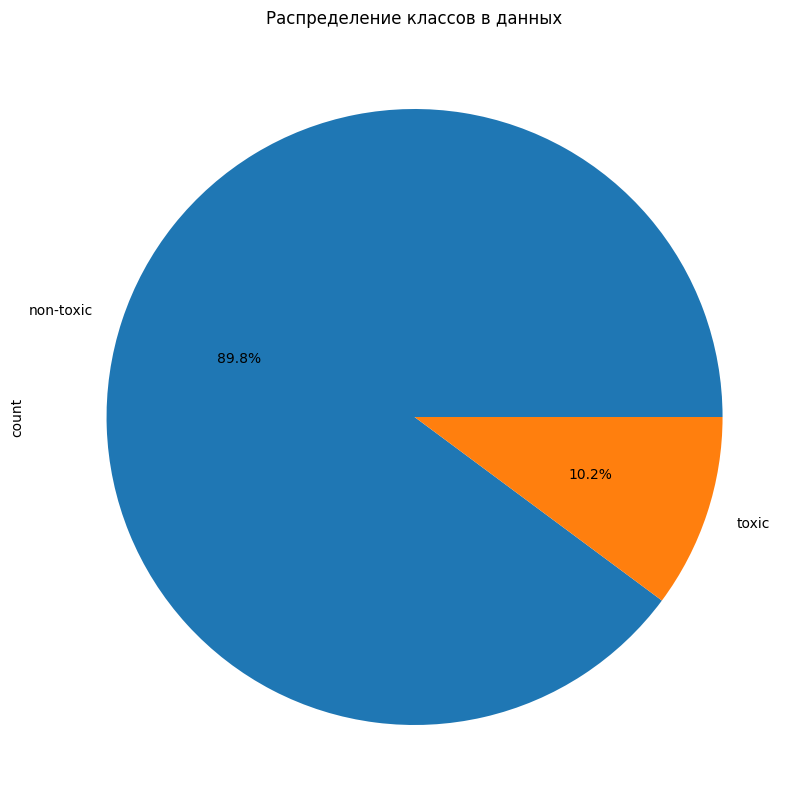

In [7]:
data['toxic'].value_counts().plot(kind='pie', figsize=(10, 10), labels=['non-toxic', 'toxic'], autopct='%1.1f%%')
plt.title('Распределение классов в данных')
plt.show()

Мы загрузили данные в датафрейм `data`, в котором содержится 159292 строчек. Данные представлены двумя колонками: 

- `text`: текст комментария на английском языке.
- `toxic`: класс комментария - токсичный (0) или нетоксичный (1).

В датафрейме нет пропусков и дубликатов.

В данных наблюдается дисбаланс классов: почти 90% комментариев не являются токсичными, только 10% являются токсичными.

### Аналих данных
Проект будет выполнятся с помощью BERT, но для анализа используем токенизатор из библиотеки nltk. Возьмем подвыборку из 1000 строк и избавимся от дисбаланса.

In [8]:
sample, rest = train_test_split(data, random_state=1, train_size=1000, stratify=data['toxic'])

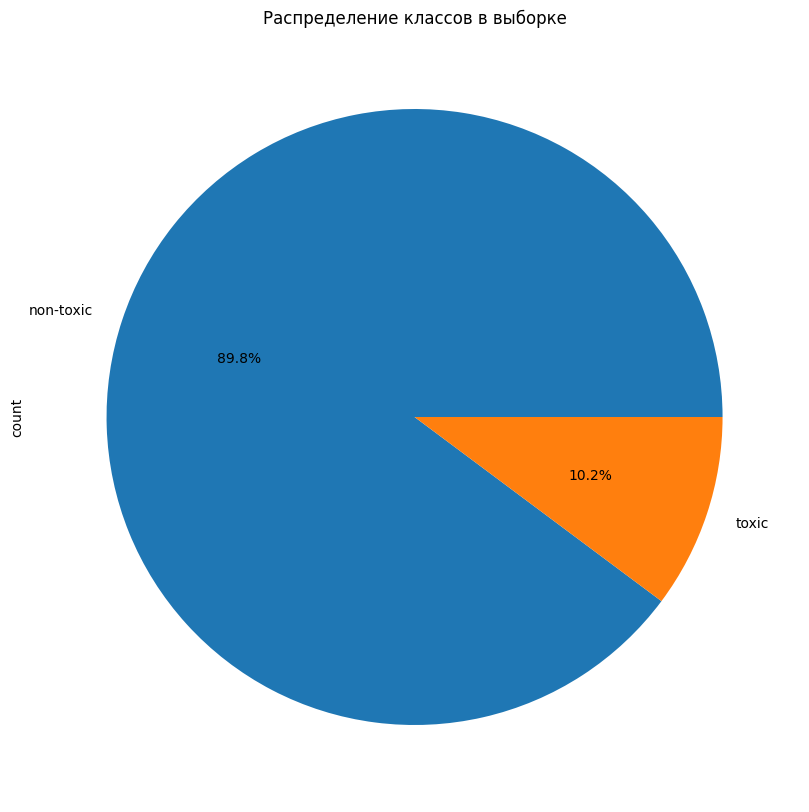

In [9]:
# проверим, что сохраился баланс классов
sample['toxic'].value_counts().plot(kind='pie', figsize=(10, 10), labels=['non-toxic', 'toxic'], autopct='%1.1f%%')
plt.title('Распределение классов в выборке')
plt.show()

In [10]:
tokens = sample.text.str.lower().apply(word_tokenize)

In [12]:
punctuation = punctuation + "'–`'—«»”•"

In [13]:
tokens

15731     [``, csd, survey, results, well, ,, i, 've, po...
154975    [blocked, again, i, have, blocked, you, again,...
151843    [citations, now, that, considerable, and, exce...
142079    [capital, tokushima, (, city, ), region, shiko...
155105    [``, image, :, futuramapilot.jpg, user, :, orp...
                                ...                        
158855    [``, coloring, could, someone, color, the, obs...
150645    [``, السلام, عليكم, ., first, ,, thank, you, f...
70262     [i, find, it, productive, ,, and, not, harmful...
19754     [``, actually, my, position, is, that, dummett...
66475     [added, the, reference, from, iss246, and, wha...
Name: text, Length: 1000, dtype: object

In [14]:
def delete_punctuators(tokens):
    tokens = [t for t in tokens if t not in punctuation]
    return [t for t in tokens if t not in ["''", "``", '...', '--']]

In [15]:
tokens = tokens.apply(delete_punctuators)

In [16]:
def delete_stop_words(tokens):
    return [t for t in tokens if t not in stopwords.words('english')]

In [17]:
tokens = tokens.apply(delete_stop_words)

In [18]:
sample['tokens_eda'] = tokens

In [19]:
all_tokens = tokens.sum()

Посмотрим на топ-15 самых частотных слов.

In [20]:
tokens_counts = Counter(all_tokens)
tokens_counts.most_common()[:15]

[("'s", 494),
 ("n't", 366),
 ('article', 344),
 ('page', 247),
 ('wikipedia', 246),
 ('talk', 203),
 ('piece', 193),
 ('would', 191),
 ('please', 185),
 ('one', 183),
 ('shitfuck', 182),
 ('know', 180),
 ('like', 154),
 ('see', 131),
 ('people', 130)]

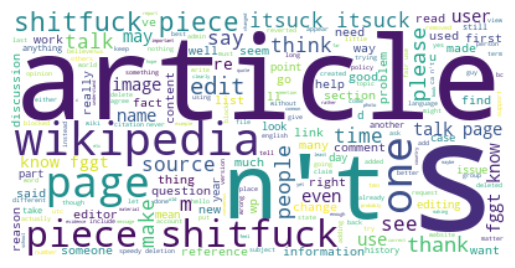

In [21]:
wordcloud = WordCloud(background_color="white").generate(' '.join(all_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Теперь посмотрим на самые частотные слова по классам.

In [22]:
def most_common_words_by_label(label):
    label_tokens = sample[sample['toxic'] == label]['tokens_eda'].sum()
    label_tokens = [t for t in label_tokens if t not in stopwords.words('english')]
    label_tokens_counts = Counter(label_tokens)
    return label_tokens_counts, label_tokens

Самые частотные токены для нетоксичных комментариев:
[("'s", 464), ('article', 341), ("n't", 339), ('page', 242), ('wikipedia', 239), ('talk', 198), ('please', 184), ('would', 183), ('one', 176), ('like', 138)]


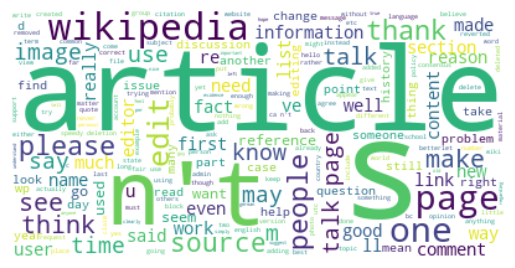

Самые частотные токены для токсичных комментариев:
[('piece', 187), ('shitfuck', 182), ('itsuck', 101), ('know', 87), ('fggt', 79), ("'s", 30), ("n't", 27), ('fuck', 23), ('get', 18), ('like', 16)]


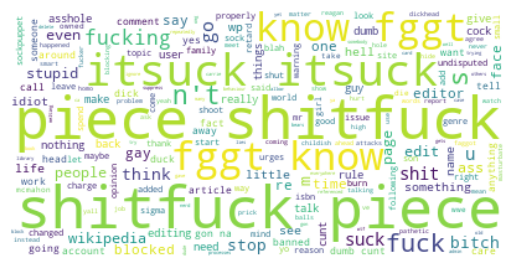

In [23]:
for label in [0, 1]:
    if label == 0:
        label_name = 'нетоксичных'
    else:
        label_name = 'токсичных'
    print(f'Самые частотные токены для {label_name} комментариев:')
    token_counts, tokens = most_common_words_by_label(label)
    print(token_counts.most_common()[:10])
    wordcloud = WordCloud(background_color="white").generate(' '.join(tokens))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()   

Можем видеть, что частотное распределение слов действительно зависит от типа комментария, т.е. скорее всего с этой задачей неплохо бы справилась и модель, использующая векторы tf-idf.

### Токенизация и создание эмбеддингов
Возьмем ту же самую выборку из 1000 примеров.

In [24]:
MODEL_NAME = 'unitary/toxic-bert'

In [25]:
print('Loading BERT tokenizer...')
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

Loading BERT tokenizer...


In [26]:
sentences = sample['text']
label = sample['toxic']

In [27]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True, 
                        max_length = 512,  
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,  
                        return_tensors = 'pt', 
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])



In [28]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [29]:
model = transformers.BertModel.from_pretrained(MODEL_NAME)

In [30]:
from tqdm import trange

In [31]:
batch_size = 100
embeddings = []
for i in trange(len(sample) // batch_size):
    batch = torch.LongTensor(input_ids[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_masks[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

100%|██████████| 10/10 [23:18<00:00, 139.83s/it]


In [32]:
features = np.concatenate(embeddings)

### Деление на train/test
Разделим наши данные на обучающую и тестовую выборки в соотношении 3:1.

In [33]:
target = label

In [34]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=1, test_size=0.25, stratify=target)

### Выводы по этапу подготовки данных
Мы загрузили данные в датафрейм `data`. Датафрейм состоит из 159292 строчек. Данные представлены двумя колонками: 

- `text`: текст комментария на английском языке.
- `toxic`: класс комментария - токсичный (0) или нетоксичный (1).

В датафрейме нет пропусков и дубликатов.

В данных наблюдается дисбаланс классов: почти 90% комментариев не являются токсичными, только 10% являются токсичными.

Далее была создана подвыборка `sample`, состоящая из 1000 примеров: 500 примеров класса `0` и 500 примеров класса `1`. Комментарии из выборки были протокенизированы токенизатором из библиотеки nltk. Списки токенов были очищены от пунктуации и стоп-слов, список которых также был взят из библиотеки nltk. Мы изучили самые частотные слова по выборке в целом, а также по каждому из классов. Было замечено, что в токсичных комментариях частотной является обсценная лексика.

На следующем этапе мы токенизировали комментарии из нашей выборки токенизатором BertTokenizer модели `unitary/toxic-bert`, которая была специально обучена для задачи классификации токсичности комментариев. Так как мы используем модель BERT, производить предобработку данных, в частности лемматизацию, очистку текстов от пунктуаторов, стоп-слов, не требуется, мы можем подавать комментарии в токенизатор as-is. Для токенизатора было выбрано значение параметра `max_length`, равное 512. Затем мы создали эмбеддинги, используя модель `unitary/toxic-bert`.

Полученные данные были поделены на обучающую и тестовую выборки в отношении 3:1.

## Обучение

### Логистическая регрессия

In [35]:
model_lr = LogisticRegression(random_state=1, solver='sag')

In [36]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)

In [37]:
params_lr = {'logisticregression__max_iter': [500, 1000]}

In [38]:
lr_pipeline = make_pipeline(SMOTE(random_state=1), model_lr)

In [39]:
lr_grid = GridSearchCV(lr_pipeline, param_grid=params_lr, cv=kf, scoring='f1', return_train_score=True)


In [40]:
lr_grid.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=1)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1,
                                                           solver='sag'))]),
             param_grid={'logisticregression__max_iter': [500, 1000]},
             return_train_score=True, scoring='f1')

In [41]:
lr_grid.best_params_

{'logisticregression__max_iter': 500}

In [42]:
f1_lr = lr_grid.best_score_
print('Best F1-score on cross-validation = {}'.format(round(f1_lr, 2)))

Best F1-score on cross-validation = 0.92


### Случайный лес

In [43]:
rfc = RandomForestClassifier(random_state=1)

In [44]:
params_rfc = {'randomforestclassifier__n_estimators' : [100, 150],
          'randomforestclassifier__max_depth': [None, 10, 20]}

In [45]:
rfc_pipeline = make_pipeline(SMOTE(random_state=1), rfc)

In [46]:
rfc_grid = GridSearchCV(rfc_pipeline, param_grid=params_rfc, cv=kf, scoring='f1', return_train_score=True)

In [47]:
rfc_grid.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=1)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=1))]),
             param_grid={'randomforestclassifier__max_depth': [None, 10, 20],
                         'randomforestclassifier__n_estimators': [100, 150]},
             return_train_score=True, scoring='f1')

In [48]:
rfc_grid.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__n_estimators': 100}

In [49]:
f1_rfc = rfc_grid.best_score_
print('Best F1-score on cross-validation = {}'.format(round(f1_rfc, 2)))

Best F1-score on cross-validation = 0.92


### Выводы по этапу обучения
Мы обучили две модели классификации: логистическую регрессию и модель случайного леса. Для модели случайного леса мы подбирали параметры `n_estimators` и `max_depth`. Обе модели преодолели значение F1-меры, указанное в условии задачи (0.75). Результаты представлены в таблице ниже:

|Модель|F1-score|
|------|-------:|
|Логистическая регрессия (max_iter = 500)|0.92|
|Случайный лес (max_depth=None, n_estimators=100)|0.92|

Обе модели продемонстрировали одинаковое качество, поэтому будем тестировать обе модели на тестовом датасете.

## Тестирование
Протестируем наши модели на тестовом датасете.

In [50]:
lr_predict_test = lr_grid.predict(features_test)

In [51]:
f1_test_lr = f1_score(target_test, lr_predict_test)
print('Logistic Regression F1-score = {}'.format(round(f1_test_lr, 2)))

Logistic Regression F1-score = 0.98


In [52]:
rfc_predict_test = rfc_grid.predict(features_test)
f1_test_rfc = f1_score(target_test, rfc_predict_test)
print('Logistic Regression F1-score = {}'.format(round(f1_test_rfc, 2)))

Logistic Regression F1-score = 0.96


На тестовой выборке модель логистической регрессии продемонстрировала качество F1-score = 0.98, а модель случайного леса F1-score = 0.96. Таким образом, модель логистической регрессии продемонстрировала лучший результат.

## Проверка модели на адекватность
Выберем стратегию предсказаний `stratified`.

In [59]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

In [60]:
dummy_clf.fit(features_train, target_train)

DummyClassifier(random_state=42, strategy='stratified')

In [61]:
predict_dummy = dummy_clf.predict(features_test)
f1_dummy = f1_score(target_test, predict_dummy)
print('F1-score = {}'.format(round(f1_dummy, 2)))

F1-score = 0.19


Качество DummyClassifier-а на тестовой выборке заметно ниже, чем качество обученного нами классификатора. Модель прошла проверку на адекватность.

## Выводы

Мы обучили модель, определяющую токсичность комментария в интернете. Для достижения этой цели были выполнены следующие шаги:
1. **Загрузка, анализ и поготовка данных**. Мы загрузили данные в датафрейм `data`. Датафрейм состоит из 159292 строчек. Данные представлены двумя колонками: 

    - `text`: текст комментария на английском языке.
    - `toxic`: класс комментария - токсичный (0) или нетоксичный (1).

    В датафрейме нет пропусков и дубликатов.

    В данных наблюдается дисбаланс классов: почти 90% комментариев не являются токсичными, только 10% являются токсичными.

    Далее была создана подвыборка `sample`, состоящая из 1000 примеров: 500 примеров класса `0` и 500 примеров класса `1`. Комментарии из выборки были протокенизированы токенизатором из библиотеки nltk. Списки токенов были очищены от пунктуации и стоп-слов, список которых также был взят из библиотеки nltk. Мы изучили самые частотные слова по выборке в целом, а также по каждому из классов. Было замечено, что в токсичных комментариях частотной является обсценная лексика.

    На следующем этапе мы токенизировали комментарии из нашей выборки токенизатором BertTokenizer модели `unitary/toxic-bert`, которая была специально обучена для задачи классификации токсичности комментариев. Так как мы используем модель BERT, производить предобработку данных, в частности лемматизацию, очистку текстов от пунктуаторов, стоп-слов, не требуется, мы можем подавать комментарии в токенизатор as-is. Для токенизатора было выбрано значение параметра `max_length`, равное 512. Затем мы создали эмбеддинги, используя модель `unitary/toxic-bert`.

    Полученные данные были поделены на обучающую и тестовую выборки в отношении 3:1.

2. **Обучение и валидация моделей**. Мы обучили две модели классификации: логистическую регрессию и модель случайного леса. Для модели случайного леса мы подбирали параметры `n_estimators` и `max_depth`. Для модель логистической регрессии подбирался параметр `max_iter`. Обе модели преодолели значение F1-меры, указанное в условии задачи (0.75). Результаты представлены в таблице ниже:

    |Модель|F1-score|
    |------|-------:|
    |Логистическая регрессия (max_iter = 500)|0.92|
    |Случайный лес (max_depth=None, n_estimators=100)|0.92|

    На валидационной выборке обе модели продемонстрировали одинаковое качество.

3. **Тестирование модели**. Мы протестировали обе обученные нами модели на тестовом датасете. Модель логистической регрессии продемонстрировала качество F1-score = 0.98, а модель случайного леса F1-score = 0.96. Таким образом, модель логистической регрессии продемонстрировала лучший результат.

4. **Проверка модели на адекватность**. Мы сравнили качество нашей модели с качеством модели DummyClassifier, которая предсказывает класс по распределению классов в обучающей выборке. DummyClassifier демонстрирует качество F1-score = 0.19, что ниже качества обеих моделей. Модели прошли проверку на адекватность.
